## TO-DO

2. Grid-Search optimal parameters
    * Train different epochs
    * Train different LR
    * Train different batch size
3. Apply image data augmentation from machinelearningmastery handwritten digits tutorial
4. Deeper Network Topology

# Object Recognition using the CIFAR-10 dataset

The CIFAR-10 dataset consists of 60,000 photos divided into 10 classes. The images are in RGB and 32 by 32 pixels.

Let's download the dataset using Keras and then load the data into training and test sets.

Using TensorFlow backend.


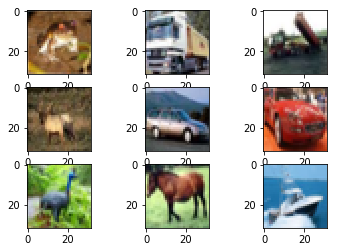

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.misc import toimage
import numpy
# Importing Keras for CNN model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D, Lambda
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras_tqdm import TQDMNotebookCallback
from time import time
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproductibility
seed = 5
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0
# one hot encode outputs - converts the classes into a binary matrix with a width of 10.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# Let's visualize what some of the images look like
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(X_train[i]))
# show the plot
plt.show()

# Models

We will be comparing two different models to find out which is more accurate and efficient. We will evaluate the models without image augmentation and then with image augmentation.

Model 1 will be my own custom CNN model. Model 2 will be a re-implementation of: https://arxiv.org/pdf/1412.6806.pdf.

## Baseline model

Before creating the model 1 and 2, let's build a baseline model to compare our models to.

In [3]:
base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
base_model.add(Dropout(0.2))
base_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
base_model.add(Dropout(0.5))
base_model.add(Dense(10, activation='softmax'))
# Compile model
epochs = 25
LR = 0.001
decay = LR/epochs
adam = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
base_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [4]:
history = base_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32, verbose=0, callbacks=[TQDMNotebookCallback()])

In [5]:
# Final evaluation of the model
scores = base_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 69.41%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


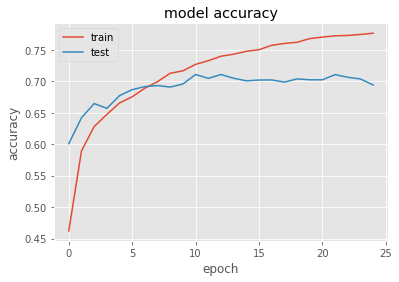

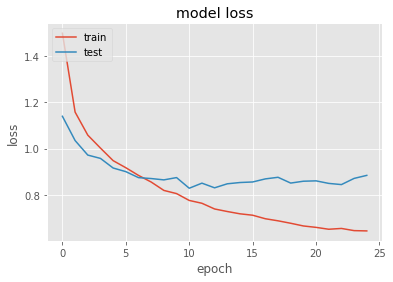

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 1

In [10]:
# Create the model
custom_model = Sequential()
custom_model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
custom_model.add(MaxPooling2D(pool_size=(2,2)))
# custom_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# custom_model.add(Dropout(0.2))

# custom_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Flatten())
custom_model.add(Dropout(0.2))

custom_model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
custom_model.add(Dropout(0.2))

custom_model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
custom_model.add(Dropout(0.2))

custom_model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 100
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
custom_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(custom_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 16, 16)        36928     
__________

In [8]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [16]:
from keras.callbacks import EarlyStopping
callbacks = [TQDMNotebookCallback(), EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
history_custom_model = custom_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, verbose=0, callbacks=callbacks)

In [17]:
# Final evaluation of the model
scores = custom_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.33%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


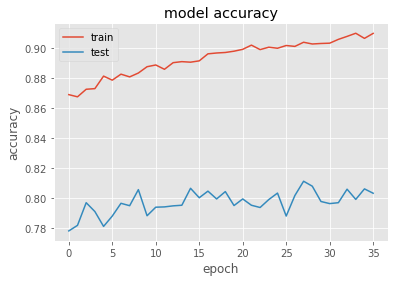

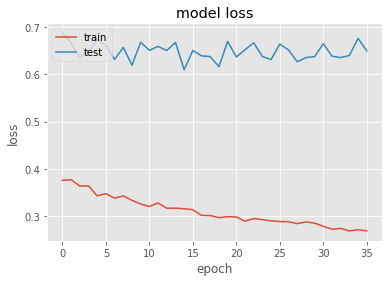

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# list all data in history
print(history_custom_model.history.keys())
# summarize history for accuracy
plt.plot(history_custom_model.history['acc'])
plt.plot(history_custom_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_custom_model.history['loss'])
plt.plot(history_custom_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 2: STRIVING FOR SIMPLICITY

We will be using a version of the neural network used in the publication "STRIVING FOR SIMPLICITY: THE ALL CONVOLUTIONAL NET" by Springenberg et al.

Like we did in model 1, most modern CNNs used for object detection are built by alternating convolutional and max-pooling layers followed by a small number of fully connected layers. The article questions the necessity of this structure and instead of max-pooling, it uses convolutional layers with increased stride.